In [368]:
import torch, random, conflicts
import numpy as np
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from collections import deque
from IPython import display
from tqdm import tqdm
import seaborn as sns
import sklearn.manifold
sns.set(style='darkgrid')

### Unit-Wise Change Detection as Set-Shifting

In [2]:
cd_net = conflicts.UnitWiseConflictMonitoringNet(gpu_id=0, input_size=4, output_size=1, hidden_size=256, rnn_type='gru', rnn_hidden_size=128, rnn_num_layers=2).cuda()
fc_net = conflicts.CDControlForward(input_size=4, output_size=1).cuda()
rn_net = conflicts.CDControlRecurrent(input_size=4, output_size=1).cuda()
cd_adam = torch.optim.Adam(cd_net.parameters(), 1e-4)
fc_adam = torch.optim.Adam(fc_net.parameters(), 1e-4)
rn_adam = torch.optim.Adam(rn_net.parameters(), 1e-4)

In [3]:
def sinc(x):
    y = torch.sin(x) / x
    y[y!=y] = 1.  # deal with x=0
    return y

In [4]:
def sample_mk1(x=None, n=32):
    cut = list(range(100, 400))
    fcn = random.sample([torch.sin, torch.cos, torch.tanh], 3)
    t = torch.linspace(-2, 2, 512).view(1, -1, 1).sin().cuda()
    j = sorted(random.sample(cut, 2))
    data = torch.cat([
        fcn[0](t[:,     :j[0], :1].mul(3)).add(0.5), 
        fcn[1](t[:, j[0]:j[1], :1].mul(7)).add(-0.5),
        fcn[2](t[:, j[1]:,     :1].mul(5)).add(-0.1)
    ], dim=1)
#     x = data[:, :-1]
#     y = data[:, 1:]

    return t, data

def sample_mk2(x=None, n=32):
    # 1D input to 2D output
    ad1 = random.sample([-1.0, -0.5, 0.0, 0.5, 1.0], 3)
    ad2 = random.sample([-1.0, -0.5, 0.0, 0.5, 1.0], 3)
    fq1 = random.sample([3, 7, 10, 17], 3)
    fq2 = random.sample([3, 7, 10, 17], 3)
    cp1 = sorted(random.sample(list(range(100, 400)), 2))
    cp2 = sorted(random.sample(list(range( 80, 450)), 3))
    fcn = random.sample([torch.sin, torch.cos, torch.tanh, sinc], 3)
    t = torch.linspace(-2, 2, 512).view(1, -1, 1).mul(3).cos().cuda()
    data = torch.cat([
        torch.cat([
            fcn[0](t[:,       :cp1[0], :1].mul(fq1[0])).add(ad1[0]), 
            fcn[1](t[:, cp1[0]:cp1[1], :1].mul(fq1[1])).add(ad1[1]),
            fcn[2](t[:, cp1[1]:,       :1].mul(fq1[2])).add(ad1[2])
        ], dim=1),
        torch.cat([
            fcn[0](t[:,       :cp2[0], :1].mul(fq2[0])).add(ad2[0]), 
            fcn[1](t[:, cp2[0]:cp2[1], :1].mul(fq2[1])).add(ad2[1]),
            fcn[2](t[:, cp2[1]:cp2[2], :1].mul(fq2[2])).add(ad2[2]),
            fcn[0](t[:, cp2[2]:      , :1].mul(fq2[1])).add(ad2[0])
        ], dim=1)  
    ], dim=2)

    return t, data

def sample_mk3(x=None, n=32):
    cut = (torch.clamp(torch.rand(20), min=0.4) * 200).long()
    cut = torch.cumsum(cut[1 - (torch.cumsum(cut, 0) > 512)], 0)
    if cut[-1] == 512:
        cut = cut[:-1]
    
    t = torch.linspace(-2, 2, 512).view(1, -1, 1).cuda()
    x = torch.cat([
        t.cos(), t.mul(2).cos(), t.mul(4).cos(), t.mul(8).cos()], dim=2)
    
    data = []
    for i in range(cut.size(0)+1):
        fcn = random.sample([torch.sin, torch.cos, torch.tanh, sinc], 4)
        if i % 2 == 0:
            fm = random.sample([8, 12, 13, 15], 4)
        else:
            fm = random.sample([ 1,  2,  3,  5], 4)
        if i == 0:
            slc = slice(None, cut[i])
        elif i == cut.size(0):
            slc = slice(cut[i-1], None)
        else:
            slc = slice(cut[i-1], cut[i])

        data.append(
            ( fcn[0](x[:, slc,  :1].mul(fm[0])) + fcn[1](x[:, slc, 1:2].mul(fm[0])) 
            + fcn[2](x[:, slc, 2:3].mul(fm[0])) + fcn[3](x[:, slc, 3: ].mul(fm[0])) ))

    return x, torch.cat(data, dim=1), cut

def sample_mk4(x=None, n=32, fn=torch.sin):
    cut = random.sample(list(range(10, 500)), 1)[0]
    pha = random.sample(np.linspace(-2, 2, 31).tolist(), 8)
    frq = random.sample(np.linspace(1, 12, 31).tolist(), 8)
    t = torch.linspace(-2, 2, 512).view(1, -1, 1).cuda()
    x = torch.cat([
        t.cos(), t.mul(2).cos(), t.mul(4).cos(), t.mul(8).cos()], dim=2)
    data = [
        ( fn(x[:, :cut,  :1] * frq[0] + pha[0])
        - fn(x[:, :cut, 1:2] * frq[1] + pha[1])
        + fn(x[:, :cut, 2:3] * frq[2] + pha[2])
        + fn(x[:, :cut, 3: ] * frq[3] + pha[3])),
        ( fn(x[:, cut:,  :1] * frq[4] + pha[4])
        - fn(x[:, cut:, 1:2] * frq[5] + pha[5])
        + fn(x[:, cut:, 2:3] * frq[6] + pha[6])
        + fn(x[:, cut:, 3: ] * frq[7] + pha[7]))
    ]  

    return x, torch.cat(data, dim=1), cut

42


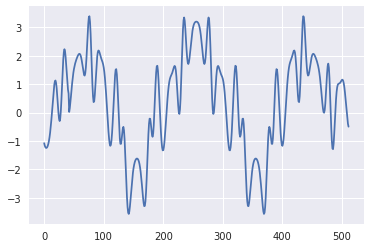

In [5]:
%matplotlib inline
x, y, cut = sample_mk4()
print(cut)
plt.plot(y.squeeze().detach().cpu().numpy())
plt.show()

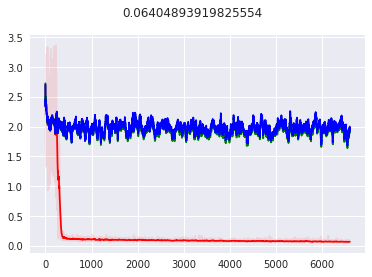

KeyboardInterrupt: 

In [6]:
cd_history, fc_history, rn_history = [], [], []
smoothed_cd_history, smoothed_fc_history, smoothed_rn_history = [], [], []
cd_deq, fc_deq, rn_deq = deque([], maxlen=30), deque([], maxlen=30), deque([], maxlen=30)

for i in range(30000):
    x, y, cut = sample_mk4()
    
    cd_net.reset_rnn()
    _, loss_0, loss_1 = cd_net(x, y, carryover=1)
    loss = (loss_1.mean() - 1e-4 * loss_0.mean() + 1e-7 * cd_net.ccd_regulariser)
    loss.backward()
    cd_adam.step()
    cd_adam.zero_grad()
    
    cd_deq.append(float(loss_1.mean()))
    cd_history.append(cd_deq[-1])
    smoothed_cd_history.append(np.mean(cd_deq))
    
    _, loss_0 = fc_net(x, y)
    loss = loss_0.mean()
    loss.backward()
    fc_adam.step()
    fc_adam.zero_grad()
    
    fc_deq.append(float(loss))
    fc_history.append(fc_deq[-1])
    smoothed_fc_history.append(np.mean(fc_deq))
    
    _, loss_0 = rn_net(x, y)
    loss = loss_0.mean()
    loss.backward()
    rn_adam.step()
    rn_adam.zero_grad()
    
    rn_deq.append(float(loss))
    rn_history.append(rn_deq[-1])
    smoothed_rn_history.append(np.mean(rn_deq))
    
    if (i+1) % 50 == 0:
        display.clear_output(wait=True)
        plt.plot(cd_history, 'r', alpha=.1)
        plt.plot(smoothed_cd_history, 'r')
        plt.plot(smoothed_fc_history, 'g')
        plt.plot(smoothed_rn_history, 'b')
        plt.suptitle(np.min(smoothed_cd_history))
        plt.show()

In [7]:
# torch.save(cd_net.state_dict(), 'outlet/unit-wise-change-detection-cd-mk4.pt')
# torch.save(fc_net.state_dict(), 'outlet/unit-wise-change-detection-fc-mk4.pt')
# torch.save(rn_net.state_dict(), 'outlet/unit-wise-change-detection-rn-mk4.pt')

In [422]:
x, y, cut = sample_mk4(fn=torch.tanh)

In [423]:
# x, y, cut = torch.load('outlet/for-video/mk4/tsne-xi-02-data.pt')

In [424]:
# t = torch.linspace(-5, 5, 512).view(1, -1, 1).cuda()
# m = torch.linspace(1, 20, 256).view(1, -1, 1).cuda()
# y = torch.cat([(t[:, :256] * m).sin(), (t[:, 256:] * m).cos()], dim=1)

In [425]:
# m = np.linspace(np.pi*2, 0, 240)
# t = np.linspace(-2*np.pi, 2*np.pi, 240)
# p = np.linspace(-2*np.pi, 2*np.pi, 240)
# y = np.cos(t * m + p) - 1.0
# t = np.linspace(0, np.pi/2, 32)
# y = np.concatenate([y, np.sin(t*0.9-0.01)+0.08])
# t = np.linspace(0, 4*np.pi, 240)
# y = np.concatenate([y, np.sin(t * m[::-1]) + 1.1])
# y = torch.tensor(y, dtype=torch.float32, device='cuda').view(1, -1, 1)
# x = x + torch.randn(x.size()).cuda() * 0.01
# cut = [240, 272]

In [426]:
cd_net.reset_rnn()
cd_net.eval();

In [427]:
y_hat_cd, _, _ = cd_net(x, y)
y_hat_fc, _ = fc_net(x, y)
y_hat_rn, _ = rn_net(x, y)

In [ ]:
t = np.linspace(0, 511, 512)
plt.figure(figsize=(9, 11))

ax = plt.subplot2grid((9, 1), (0, 0), rowspan=2)
ax.plot(t, x.squeeze().detach().cpu().numpy())
ax.set_title('Inputs')
ax.set_xlim([0, 511])
ax.set_xticks([])

ax = plt.subplot2grid((9, 1), (2, 0), rowspan=1)
ax.imshow(np.cos(np.tile(np.linspace(-2, 2, 512), (4, 1)) * np.array([[1, 2, 4, 8]]).T), 
           extent=[0, 511, 0, 1], cmap='gray', interpolation=None, aspect='auto')
ax.set_yticks([])
ax.grid()

ax = plt.subplot2grid((9, 1), (4, 0), rowspan=2)
ax.plot(t, y.squeeze().detach().cpu().numpy(), 'k-', linewidth=3, alpha=.5, label='Ground Truth')
ax.plot(t, y_hat_cd.squeeze().detach().cpu().numpy(), 'r:', linewidth=3, alpha=1, label='Conflict monitoring')
ax.plot(t, y_hat_fc.squeeze().detach().cpu().numpy(), 'g:', linewidth=3, alpha=1, label='Feedforward')
ax.plot(t, y_hat_rn.squeeze().detach().cpu().numpy(), 'b:', linewidth=3, alpha=1, label='Recurrent')
ax.legend(bbox_to_anchor=(0.1, 0.11, .9, .102), loc=0, ncol=2, borderaxespad=0.)
ax.set_title('Prediction: tested with functions unencountered during training')
ax.set_ylim([-3., 4.1])
ax.set_xlim([0, 511])

ax = plt.subplot2grid((9, 1), (7, 0), rowspan=2)
ax.plot(t, (y_hat_cd - y).pow(2).sqrt().squeeze().detach().cpu().numpy())
# plt.gca().set_title( ('Conflict signals; switching points: ' + ','.join(['{}'] * cut.size(0))).format(*cut.numpy()) )
ax.set_title( ('Conflict indices: peak at $t={}$').format(t[cut]))
ax.set_ylim([0, 1.2])
ax.set_xlim([0, 511])

# plt.savefig('outlet/for-video/mk4/time-conflict-plot-03a.png', dpi=300)

plt.show()

---

### Embedding

In [42]:
from mpl_toolkits.mplot3d import Axes3D

In [257]:
logits = cd_net.on_logits(cd_net.first_pass(x, y)[1])

In [258]:
logits_cat = torch.cat(logits, dim=1).squeeze(0).permute(1, 0)

#### Bernoulli samples

In [146]:
eps = 1e-7
for i in range(512):
    pr = F.sigmoid(logits_cat[i])
    us = torch.rand(pr.size(), device=pr.device)
    cdp = ((pr + eps).log() - (1 - pr + eps).log()
          +(us + eps).log() - (1 - us + eps).log())
    cdp = F.sigmoid(cdp / 0.1)

    plt.hist((1 - cdp).detach().cpu().numpy().ravel(), 100)
    plt.ylim([0, 350])
    plt.title('$t=${}'.format(i+1))
#     plt.savefig('outlet/for-video/indep/retain-by-time/retain-{:07d}.png'.format(i+1))
    plt.close()

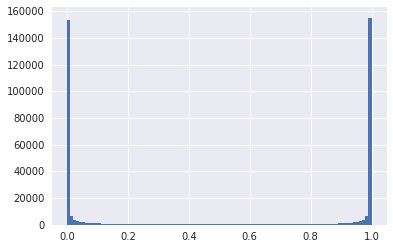

In [169]:
pr = F.sigmoid(logits_cat)
us = torch.rand(pr.size(), device=pr.device)
cdp = ((pr + eps).log() - (1 - pr + eps).log()
      +(us + eps).log() - (1 - us + eps).log())
cdp = F.sigmoid(cdp / 0.1)

plt.hist((1 - cdp).detach().cpu().numpy().ravel(), 100)
plt.show()

#### 2D visualisation

In [374]:
tsne2 = sklearn.manifold.TSNE(n_components=2)

In [377]:
tsne_fit2 = tsne2.fit_transform(logits_cat.detach().cpu().numpy())

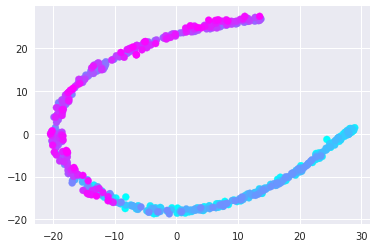

In [378]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(tsne_fit2[:, 0], tsne_fit2[:, 1], c=np.linspace(0, 1, 512), cmap='cool')
plt.show()

#### 3D visualisation

In [262]:
tsne3 = sklearn.manifold.TSNE(n_components=3)

In [263]:
tsne_fit3 = tsne3.fit_transform(logits_cat.detach().cpu().numpy())

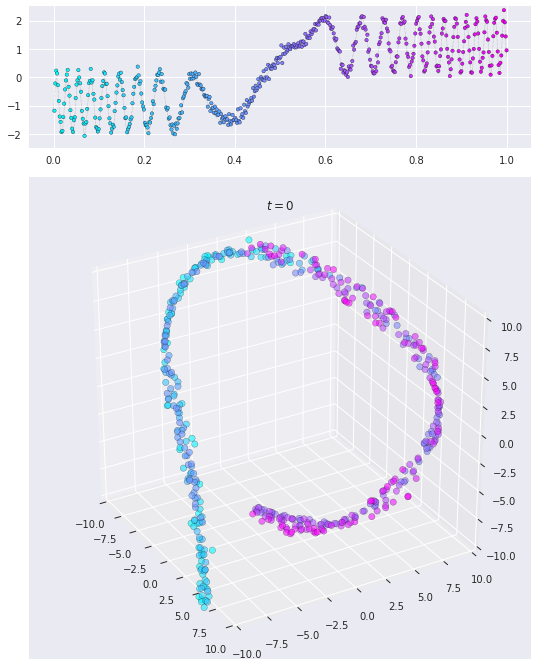

In [373]:
%matplotlib inline
fig = plt.figure(figsize=(9, 12))
ax = plt.subplot2grid((4, 1), (0, 0))
ax.plot(np.linspace(0, 1, 512), y.squeeze().detach().cpu().numpy(), ':k', linewidth=0.5, alpha=.4, label='Ground Truth')
ax.scatter(np.linspace(0, 1, 512), y_hat_cd.squeeze().detach().cpu().numpy(), marker='.', cmap='cool', c=np.linspace(0, 1, 512), vmax=1, vmin=0, edgecolors='k')
# ax.plot([0, 0], [-2.5, 2.5], 'k:', alpha=0.7)
ax.set_ylim([-2.5, 2.5])

ax = plt.subplot2grid((4, 1), (1, 0), rowspan=3, projection='3d')
ax.view_init(elev=30, azim=330.)
ax.scatter(tsne_fit3[:, 0], tsne_fit3[:, 1], tsne_fit3[:, 2], c=c[:], s=40, cmap='cool', vmax=1, vmin=0, edgecolors='k')
ax.set_title('$t=0$')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])

# plt.savefig('outlet/for-video/indep/tsne-xi-02/tsne-xi-02-tsplot.png', dpi=300)
plt.show()

In [256]:
# torch.save([x, y, cut, tsne_fit2, tsne_fit3], 'outlet/for-video/indep/tsne-xi-02-data.pt')

In [371]:
%matplotlib inline 
c = np.linspace(0, 1, 512)
for i in tqdm(range(1, 513)):
    fig = plt.figure(figsize=(9, 12))
    ax = plt.subplot2grid((4, 1), (0, 0))
    ax.plot(np.linspace(0, 1, 512), y.squeeze().detach().cpu().numpy(), ':k', linewidth=0.5, alpha=.4)
    ax.scatter(c, y_hat_cd.squeeze().detach().cpu().numpy(), marker='.', cmap='cool', c=c, vmax=1, vmin=0, edgecolors='k')
    ax.plot([c[i-1], c[i-1]], [-2.5, 2.5], 'k:', alpha=0.7)
    ax.set_ylim([-2.5, 2.5])
    
    ax = plt.subplot2grid((4, 1), (1, 0), rowspan=3, projection='3d')
    ax.view_init(elev=30, azim=(330. + i * 360/512) % 360)
    ax.scatter(tsne_fit3[:i, 0], tsne_fit3[:i, 1], tsne_fit3[:i, 2], c=c[:i], s=40, cmap='cool', vmax=1, vmin=0, edgecolors='k')
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    ax.set_title('$t=${}'.format(i))
#     plt.savefig('outlet/for-video/indep/tsne-xi-02/rotating-frame/xi-{:04d}.png'.format(i))
    plt.close()

100%|██████████| 512/512 [02:08<00:00,  3.97it/s]
